# Coronavirus Forecast
A simple Python script to forecast the emergence of COVID-19 cases in different countries based on a logistic model

In [20]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tic
import scipy.optimize as opt
from math import log

from importnb import Notebook
with Notebook(): 
    import coronavirus_data

## Get data for a number of places and do some pre-processing

In [21]:
places = [
    'Hubei',
    'Germany',
    'Italy',
    'Netherlands',
    'Poland'
]
dataset = [np.array(coronavirus_data.get_series(place, 'Confirmed')) for place in places]
index = np.arange(len(dataset[0]))
average = np.average(dataset, axis=0)

## Define some more data for places and approximations

In [25]:
inhabitants = [
    58.5*10**6,
    82.79*10**6,
    60.48*10**6,
    17.18*10**6,
    38.65*10**6
]
base_fraction = 0.00116 # Ratio between confirmed cases and inhabitants at the end of the modelled period (assuming there is only a single wave and based on Hubei!)
duration = 14 # Duration of infection/Days after which the cases become non-active (either due to recovery or death)
time = 100 # Number of days to model

## Insert the restriction-factor for each country

In [ ]:
# dependig on how strict the restrictions in each country is (Hubei is ref, giving -> base_fraction)
# the higher the number -> the more restricted the people are
# a lower restriction factor means a higher number of the population will be affected in TOTAL (0 means 100% of population is infected)
# NOTE: restriction_factor is purely arbitrary for speculatory purposes only!! 

def calc_fraction(x):
    return log(x, 1e-20) + base_fraction

restrictions_on = True  # toggle restrictions factoring in the final fractions!
restriction_factors = {
    'Hubei': 1,
    'Germany': 0.9,
    'Italy': 0.95,
    'Netherlands': 0.8,
    'Poland': 0.98,
}
ordered_factors = [restriction_factors[place] for place in places]  # ensure that the factors are in the correct order

# Ratio between confirmed cases and inhabitants at the end of the modelled period - corrected by restrictions
if restrictions_on:
    fractions = np.array([calc_fraction(fac) for fac in ordered_factors])
else:
    fractions = np.array([base_fraction] * len(places))

print(fractions)

## Investigate places seperately

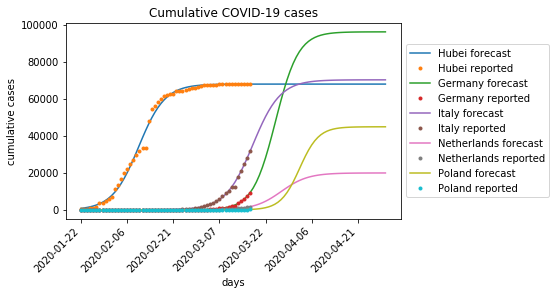

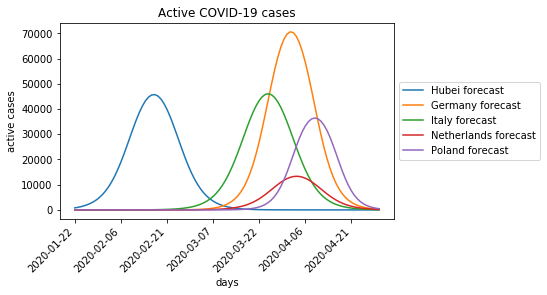

In [28]:
fig1, axs1 = plt.subplots()
fig2, axs2 = plt.subplots()

cumulative_pc = []
active_pc = []
for i in range(len(places)):
    
    fraction = fractions[i]
    def logistic_model(x,a,b):
        return inhabitants[i]*fraction/(1+np.exp(-(x-b)/a))
    fit = opt.curve_fit(logistic_model, index, dataset[i])
    
    cumulative = np.array([logistic_model(j, fit[0][0], fit[0][1]) for j in np.arange(time)])
    cumulative_pc.append(cumulative / inhabitants[i])
    decay = np.array([logistic_model(j-duration, fit[0][0], fit[0][1]) for j in np.arange(time)])
    decay_pc = decay / inhabitants[i]
    active = (cumulative-decay)
    active_pc.append(active / inhabitants[i])
    
    axs1.plot(np.arange(time), cumulative,
               label='{} forecast'.format(places[i]))
    axs1.plot(index, dataset[i], marker = '.', linestyle = 'None',
               label='{} reported'.format(places[i]))
    
    axs2.plot(np.arange(time), active,
               label='{} forecast'.format(places[i]))

axs = [axs1, axs2]
figs = [fig1, fig2]
for ax, fig in zip(axs,figs):
    ax.set_xlabel('days')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    def to_date(x, pos, today=datetime.datetime.strptime(coronavirus_data.get_series(places[0], 'Confirmed').index[0], '%m/%d/%y').date()):
        return today+datetime.timedelta(days=x)
    fmt = tic.FuncFormatter(to_date)
    ax.xaxis.set_major_formatter(fmt)
    ax.xaxis.set_major_locator(plt.MaxNLocator(8))
    fig.autofmt_xdate(rotation=45)

axs1.set_ylabel('cumulative cases')
axs2.set_ylabel('active cases')
axs1.set_title('Cumulative COVID-19 cases')
axs2.set_title('Active COVID-19 cases')
plt.show()

In [ ]:
fig1, axs1 = plt.subplots()
fig2, axs2 = plt.subplots()

for i in range(len(places)):
    axs1.plot(np.arange(time), cumulative_pc[i],
               label='{} forecast'.format(places[i]))
    axs2.plot(np.arange(time), active_pc[i],
               label='{} forecast'.format(places[i]))

axs = [axs1, axs2]
figs = [fig1, fig2]
for ax, fig in zip(axs,figs):
    ax.set_xlabel('days')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    def to_date(x, pos, today=datetime.datetime.strptime(coronavirus_data.get_series(places[0], 'Confirmed').index[0], '%m/%d/%y').date()):
        return today+datetime.timedelta(days=x)
    fmt = tic.FuncFormatter(to_date)
    ax.xaxis.set_major_formatter(fmt)
    ax.xaxis.set_major_locator(plt.MaxNLocator(8))
    fig.autofmt_xdate(rotation=45)

axs1.set_ylabel('cumulative cases')
axs2.set_ylabel('active cases')
axs1.set_title('Cumulative COVID-19 cases - PER CAPITA')
axs2.set_title('Active COVID-19 cases - PER CAPITA')
plt.show()